In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]

N_r = 1
L_r = 1

N_t = 16
L_t = 16

initial_position_cartesian = cylindrical_to_cartesian([3, math.radians(33), 0])
initial_position_cartesian 

array([2.5160117 , 1.63391711, 0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

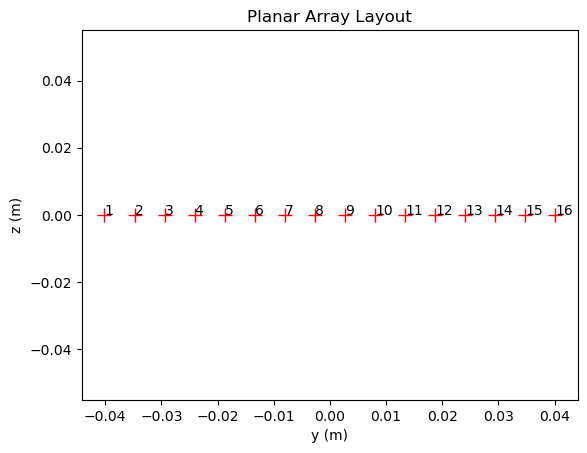

In [4]:
scene.frequency = 28e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")


scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")

scene.tx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)

In [5]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [6]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [1.96601, 1.38392, 0.84],
      max = [3.06601, 1.88392, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
        

In [7]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [8]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 1, 1, 16, 19, 1), dtype=complex64, numpy=
array([[[[[[[-1.7495845e-06+3.0937440e-06j],
            [-6.2008166e-07+3.1571126e-06j],
            [-3.4735663e-06-1.9208840e-06j],
            [ 3.1727507e-06+2.3071300e-06j],
            [ 6.0599064e-08+2.7835245e-06j],
            [ 3.0802914e-06-2.6267367e-06j],
            [-8.0662517e-08-3.4852897e-06j],
            [ 3.3142519e-06-4.0445752e-07j],
            [ 1.3476518e-06-3.2813884e-06j],
            [-2.4000256e-06-4.9780101e-07j],
            [-1.3339622e-06+3.1407260e-06j],
            [ 2.7431267e-06-2.0533050e-06j],
            [-2.8255004e-06-3.2196624e-08j],
            [ 3.7349773e-06+4.7999720e-09j],
            [ 2.6399298e-06-1.8865242e-06j],
            [ 1.9339786e-06-2.0744433e-06j],
            [-3.8336284e-06-1.3856609e-06j],
            [-2.2639023e-07+3.7859429e-06j],
            [ 1.8350670e-07+3.4463251e-06j]],

           [[-3.2155524e-06-1.5141064e-06j],
            [-3.2174200e-06-8.3

In [10]:
# Azimuth angle of arrival and departure
azimuth_departure_list = []
azimuth_arrival_list = []

for path_idx in range(a.shape[-2]):
    azimuth_departure_list.append(np.rad2deg(paths.phi_t[0,0,0,path_idx]))
    azimuth_arrival_list.append(np.rad2deg(paths.phi_r[0,0,0,path_idx]))

# Receiving Codebook

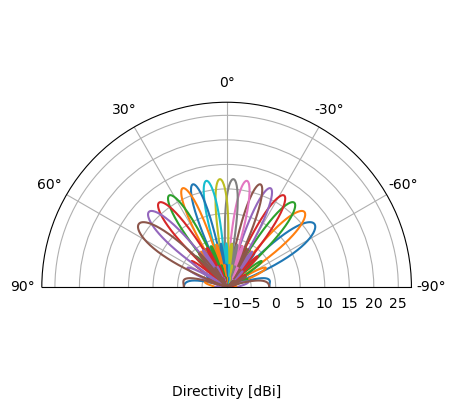

array([-52.83802756, -45.79295722, -38.74788688, -31.70281654,
       -24.6577462 , -17.61267585, -10.56760551,  -3.52253517,
         3.52253517,  10.56760551,  17.61267585,  24.6577462 ,
        31.70281654,  38.74788688,  45.79295722,  52.83802756])

In [11]:
transmitting_codebook = Codebook(L_max = L_t , N1 = N_t, az_min = -60, az_max = 60)
transmitting_codebook_vectors, beam_degs = transmitting_codebook.beamforming_vectors()
transmitting_codebook.plot_beamforming_polar(transmitting_codebook_vectors)
beam_degs

In [12]:
# Reverse the order of arrays
reversed_vectors = reversed(transmitting_codebook_vectors)
transmitting_codebook_vectors = list(reversed_vectors)
transmitting_codebook_vectors

[array([ 2.50000000e-01+0.j        , -2.07867403e-01+0.13889256j,
         9.56708581e-02-0.23096988j,  4.87725805e-02+0.24519632j,
        -1.76776695e-01-0.1767767j ,  2.45196320e-01+0.04877258j,
        -2.30969883e-01+0.09567086j,  1.38892558e-01-0.2078674j ,
        -2.45084105e-16+0.25j      , -1.38892558e-01-0.2078674j ,
         2.30969883e-01+0.09567086j, -2.45196320e-01+0.04877258j,
         1.76776695e-01-0.1767767j , -4.87725805e-02+0.24519632j,
        -9.56708581e-02-0.23096988j,  2.07867403e-01+0.13889256j]),
 array([ 0.25      +0.j        , -0.15859832+0.19325261j,
        -0.04877258-0.24519632j,  0.22048032+0.11784918j,
        -0.23096988+0.09567086j,  0.07257117-0.23923508j,
         0.13889256+0.2078674j , -0.24879618-0.02450429j,
         0.1767767 -0.1767767j ,  0.02450429+0.24879618j,
        -0.2078674 -0.13889256j,  0.23923508-0.07257117j,
        -0.09567086+0.23096988j, -0.11784918-0.22048032j,
         0.24519632+0.04877258j, -0.19325261+0.15859832j]),
 arr

In [13]:
# Removing the redundant dimesions from a --> (batch size (rays), receiving antennas, transmitting antennas)
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1]) 

In [14]:
# Generating a matrix out of transmitting_codebook_vectors --> # (batch size, N_t, L_t)
transmitting_codebook_matrix = np.stack(transmitting_codebook_vectors, axis = -1)  # (N_t, L_t)
# Add the dummy batch dimension
#transmitting_codebook_matrix = np.expand_dims(transmitting_codebook_matrix, axis=0).astype(np.complex64)  # (batch size, N_t, L_t)
transmitting_codebook_matrix[:,5]

array([ 2.50000000e-01+0.j        ,  1.38892558e-01+0.2078674j ,
       -9.56708581e-02+0.23096988j, -2.45196320e-01+0.04877258j,
       -1.76776695e-01-0.1767767j ,  4.87725805e-02-0.24519632j,
        2.30969883e-01-0.09567086j,  2.07867403e-01+0.13889256j,
        7.65404249e-17+0.25j      , -2.07867403e-01+0.13889256j,
       -2.30969883e-01-0.09567086j, -4.87725805e-02-0.24519632j,
        1.76776695e-01-0.1767767j ,  2.45196320e-01+0.04877258j,
        9.56708581e-02+0.23096988j, -1.38892558e-01+0.2078674j ])

In [15]:
# Beam forming at the Transmitter by applying the weights 
# (batch size, N_r, N_t) * (batch size, N_t, L_t) = (batch size, N_r, L_t))

beam_formed_transmitting_signal = tf.matmul(a_reshaped, transmitting_codebook_matrix) 
beam_formed_transmitting_signal # (batch size, N_r, L_t)

<tf.Tensor: shape=(19, 1, 16), dtype=complex64, numpy=
array([[[ 4.17373315e-07+7.03018259e-07j,
         -3.53859974e-07+8.44256590e-07j,
         -4.91157834e-07+1.20841833e-07j,
          1.28283546e-07+1.06183052e-07j,
          1.06913092e-07+1.31392682e-07j,
         -1.92034861e-07+7.53222309e-07j,
         -3.67015332e-07+7.67637175e-07j,
         -5.87943930e-07+7.85839347e-07j,
         -9.03289276e-07+8.11818040e-07j,
         -1.44219484e-06+8.56213546e-07j,
         -2.72407965e-06+9.61818387e-07j,
         -6.59467332e-06-4.44655188e-06j,
          7.12259089e-06+7.18260662e-06j,
         -3.25448525e-07+2.13231783e-06j,
          3.95897132e-07-2.09481328e-07j,
          1.31563354e-06+6.29017848e-07j]],

       [[ 3.44641933e-08-5.60328317e-09j,
          4.37116171e-07+4.25105924e-07j,
         -1.07387280e-07+8.00631881e-07j,
         -4.78000004e-07+2.64121525e-07j,
         -5.35502409e-07+1.70622968e-07j,
          2.82742008e-08+2.03645243e-08j,
          2.637949

In [16]:
def beamforming_gain(a_reshaped, beam_formed_signal, N):

    signal_mag = np.abs(a_reshaped)
    beam_formed_signal_mag = np.abs(beam_formed_signal)
    gain = beam_formed_signal_mag / signal_mag[:, :1, :1]
    gain = gain * math.sqrt(N)
    return gain
     
        
gain = beamforming_gain(a_reshaped = a_reshaped, beam_formed_signal = beam_formed_transmitting_signal, N=N_t)

In [17]:
# Create a MultiIndex with two levels for rows
multi_index = pd.MultiIndex.from_product([range(1, gain.shape[0] + 1, 1), range(1, gain.shape[2] + 1, 1)], names=['batch_size', 'beams'])

# Create a DataFrame with the MultiIndex
df = pd.DataFrame(gain.reshape(-1, 1), index=multi_index, columns=['gain'])


# Repeat each element of the lists 4 times
azimuth_departure_repeated = np.repeat(azimuth_departure_list, L_t)
azimuth_arrival_repeated = np.repeat(azimuth_arrival_list, L_t)

# Add new columns to the DataFrame
df['azimuth_arrival'] = azimuth_arrival_repeated
df['azimuth_departure'] = azimuth_departure_repeated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df)

                       gain  azimuth_arrival  azimuth_departure
batch_size beams                                               
1          1       0.920128        37.992821          28.460434
           2       1.030237        37.992821          28.460434
           3       0.569249        37.992821          28.460434
           4       0.187416        37.992821          28.460434
           5       0.190642        37.992821          28.460434
           6       0.874816        37.992821          28.460434
           7       0.957587        37.992821          28.460434
           8       1.104541        37.992821          28.460434
           9       1.366822        37.992821          28.460434
           10      1.887582        37.992821          28.460434
           11      3.251250        37.992821          28.460434
           12      8.951353        37.992821          28.460434
           13     11.384173        37.992821          28.460434
           14      2.427567        37.99

In [18]:
## This cell is to check the result with matrix multiplication.

#for i in range(a_reshaped.shape[0]):  # Iterate over the first dimension which is batch size (rays)
    
#    single_batch = a_reshaped[i, :, :]
    
#    print(f"single batch {i + 1}:\n{single_batch.numpy()}\n")
#    print(f"Azimuth angle of departure: {np.rad2deg(paths.phi_t[0,0,0,i]):.4f}\n")
#    print(f"Azimuth angle of arrival: {np.rad2deg(paths.phi_r[0,0,0,i]):.4f}\n")
    
#    for beam in transmitting_codebook_vectors:
    
#        beam = beam.astype(np.complex64)
#        beam_reshaped = np.reshape(beam, (N_t, 1))
#        beam_formed_single_batch = single_batch @ beam_reshaped
#        print(beam_formed_single_batch)
#        #beam_formed_single_batch_mag = tf.abs(beam_formed_single_batch)   
#        #print(beam_formed_single_batch_mag * math.sqrt(N_t))


In [19]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([1.6800351e-08, 1.8079598e-08, 1.6509482e-08, 1.6633944e-08,
       2.0078478e-08, 1.6303156e-08, 1.7960351e-08, 1.7594838e-08,
       1.6824425e-08, 2.1991012e-08, 1.7315008e-08, 1.7261952e-08,
       1.9865885e-08, 1.7168434e-08, 1.7968125e-08, 1.9813209e-08,
       1.6233004e-08, 1.6999588e-08, 1.8081732e-08], dtype=float32)>

In [20]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(beam_formed_transmitting_signal, (tau.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_r + 1) for j in range(1, L_t + 1)]
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

,"1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","1,9","1,10","1,11","1,12","1,13","1,14","1,15","1,16"
1.680035e-08,4.173733e-07+7.030183e-07j,-3.538600e-07+8.442566e-07j,-4.911578e-07+1.208418e-07j,1.282835e-07+1.061831e-07j,1.069131e-07+1.313927e-07j,-1.920349e-07+7.532223e-07j,-3.670153e-07+7.676372e-07j,-5.879439e-07+7.858393e-07j,-9.032893e-07+8.118180e-07j,-1.442195e-06+8.562135e-07j,-2.724080e-06+9.618184e-07j,-6.594673e-06-4.446552e-06j,7.122591e-06+7.182607e-06j,-3.254485e-07+2.132318e-06j,3.958971e-07-2.094813e-07j,1.315634e-06+6.290178e-07j
1.807960e-08,3.446419e-08-5.603283e-09j,4.371162e-07+4.251059e-07j,-1.073873e-07+8.006319e-07j,-4.780000e-07+2.641215e-07j,-5.355024e-07+1.706230e-07j,2.827420e-08+2.036452e-08j,2.637950e-08+2.830402e-08j,2.391045e-08+3.866188e-08j,2.022540e-08+5.413273e-08j,1.343381e-08+8.261782e-08j,-5.734847e-09+1.630233e-07j,-9.440870e-06+6.500200e-06j,3.763526e-06-1.620681e-06j,2.414334e-06+1.401761e-06j,1.434956e-07+1.274658e-06j,4.259164e-08-3.969578e-08j
1.650948e-08,-5.644727e-07-5.576858e-07j,-4.641720e-09+3.265288e-08j,-6.554001e-07+3.554313e-07j,-9.037039e-07-4.207496e-07j,-8.039515e-07-5.887473e-07j,-4.236654e-09-7.004771e-07j,1.421209e-07-7.377816e-07j,3.187087e-07-7.827927e-07j,5.561302e-07-8.433057e-07j,9.264069e-07-9.376803e-07j,1.662134e-06-1.125204e-06j,-1.458474e-07-5.119304e-08j,-1.366536e-05-8.078757e-06j,5.192521e-07+4.964047e-06j,-2.533825e-06+2.324597e-06j,-1.567679e-06-3.019863e-07j
1.663394e-08,2.446068e-07+5.145120e-07j,1.337820e-07-2.514966e-07j,8.735720e-07-1.313697e-07j,6.742017e-07+6.715081e-07j,5.284857e-07+7.875176e-07j,-1.663483e-07+4.678625e-07j,-2.719999e-07+4.558690e-07j,-3.985496e-07+4.415048e-07j,-5.671221e-07+4.223696e-07j,-8.264922e-07+3.929273e-07j,-1.329438e-06+3.358355e-07j,9.561845e-07+7.815234e-07j,9.858853e-06+1.196414e-05j,1.581470e-06-6.367628e-06j,3.183328e-06-1.326048e-06j,1.007448e-06+6.011035e-07j
2.007848e-08,-5.191546e-08+6.676545e-07j,-2.137773e-07+1.341870e-07j,2.645768e-07+1.032673e-07j,1.721676e-07+6.318856e-07j,4.763014e-08+6.826428e-07j,-5.401117e-07+4.621751e-07j,-7.020349e-07+3.940238e-07j,-9.232193e-07+3.009304e-07j,-1.276387e-06+1.522842e-07j,-2.009433e-06-1.562501e-07j,-4.929440e-06-1.385256e-06j,3.879491e-06+1.017738e-05j,1.910076e-07+1.127365e-06j,5.486777e-07-5.717307e-07j,1.312404e-06+1.671633e-07j,5.066853e-07+9.027634e-07j
1.630316e-08,7.396658e-07-7.614213e-07j,3.809085e-07+5.087190e-08j,-2.064761e-07-3.731781e-07j,3.933654e-07-8.638764e-07j,5.568179e-07-7.739777e-07j,9.566925e-07-1.386587e-08j,1.014898e-06+1.866283e-07j,1.085988e-06+4.315000e-07j,1.183080e-06+7.659430e-07j,1.338077e-06+1.299845e-06j,1.659669e-06+2.407591e-06j,-6.698822e-07+1.961357e-06j,7.947185e-06-1.370569e-05j,-2.444740e-06+2.766141e-07j,-2.070662e-06-2.219123e-06j,3.725530e-07-2.025967e-06j
1.796035e-08,-7.084878e-07-8.787711e-07j,1.746253e-07-6.722715e-07j,-2.972547e-08+1.201028e-08j,-5.604654e-07-3.425930e-07j,-4.687540e-07-4.323392e-07j,9.334465e-08-8.700945e-07j,2.716239e-07-8.681639e-07j,4.726127e-07-8.659882e-07j,7.211495e-07-8.633001e-07j,1.066162e-06-8.595671e-07j,1.630670e-06-8.534569e-07j,1.580591e-06+7.644587e-07j,3.190284e-06+2.409372e-06j,1.212772e-07-1.394170e-05j,-3.559453e-06+2.592183e-06j,-2.883978e-06-9.023139e-07j
1.759484e-08,-5.401182e-08-3.303207e-07j,5.531386e-07-5.697796e-07j,7.754728e-07+1.033101e-07j,1.611828e-07+2.910920e-07j,1.038088e-07+3.248078e-07j,1.916164e-07-2.665306e-07j,2.650334e-07-2.474626e-07j,3.596681e-07-2.228866e-07j,4.986385e-07-1.867967e-07j,7.473575e-07-1.222047e-07j,1.403133e-06+4.810246e-08j,5.996565e-06+8.692818e-06j,-2.457325e-06-5.692419e-06j,1.454019e-06-2.509481e-06j,8.136056e-07-9.232582e-08j,-3.898606e-07-4.175407e-07j
1.682442e-08,-5.052114e-07-6.264671e-07j,2.302882e-07-8.870642e-07j,4.810154e-07-1.944341e-07j,-1.276016e-07-7.797462e-08j,-1.118556e-07-1.031387e-07j,8.159805e-08-7.615662e-07j,2.503067e-07-8.004074e-07j,4.634535e-07-8.494806e-07j,7.679558e-07-9.195856e-07j,1.289059e-06-1.039557e-06

In [21]:
channel_magnitude_df = abs_complex_columns(df1)
channel_magnitude_df

,"1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","1,9","1,10","1,11","1,12","1,13","1,14","1,15","1,16"
1.680035e-08,8.175788e-07,9.154158e-07,5.058051e-07,1.665278e-07,1.693944e-07,7.773167e-07,8.508626e-07,9.814385e-07,1.214488e-06,1.677208e-06,2.888893e-06,7.953712e-06,1.011539e-05,2.157011e-06,4.479029e-07,1.458271e-06
1.807960e-08,3.491672e-08,6.097422e-07,8.078016e-07,5.461174e-07,5.620276e-07,3.484457e-08,3.869102e-08,4.545823e-08,5.778771e-08,8.370287e-08,1.631242e-07,1.146223e-05,4.097650e-06,2.791763e-06,1.282710e-06,5.822201e-08
1.650948e-08,7.935004e-07,3.298115e-08,7.455741e-07,9.968505e-07,9.964745e-07,7.004899e-07,7.513455e-07,8.451861e-07,1.010171e-06,1.318133e-06,2.007181e-06,1.545710e-07,1.587478e-05,4.991131e-06,3.438608e-06,1.596500e-06
1.663394e-08,5.696973e-07,2.848651e-07,8.833947e-07,9.515624e-07,9.484097e-07,4.965552e-07,5.308488e-07,5.947842e-07,7.071235e-07,9.151400e-07,1.371200e-06,1.234936e-06,1.550282e-05,6.561077e-06,3.448475e-06,1.173148e-06
2.007848e-08,6.696699e-07,2.524022e-07,2.840159e-07,6.549207e-07,6.843024e-07,7.108632e-07,8.050514e-07,9.710267e-07,1.285440e-06,2.015499e-06,5.120382e-06,1.089171e-05,1.143431e-06,7.924161e-07,1.323007e-06,1.035235e-06
1.630316e-08,1.061540e-06,3.842906e-07,4.264906e-07,9.492201e-07,9.534609e-07,9.567930e-07,1.031915e-06,1.168572e-06,1.409378e-06,1.865489e-06,2.924208e-06,2.072598e-06,1.584310e-05,2.460339e-06,3.035152e-06,2.059936e-06
1.796035e-08,1.128802e-06,6.945812e-07,3.206010e-08,6.568801e-07,6.376891e-07,8.750872e-07,9.096637e-07,9.865589e-07,1.124875e-06,1.369510e-06,1.840509e-06,1.755752e-06,3.997873e-06,1.394222e-05,4.403308e-06,3.021837e-06
1.759484e-08,3.347074e-07,7.941102e-07,7.823241e-07,3.327378e-07,3.409933e-07,3.282612e-07,3.626023e-07,4.231307e-07,5.324786e-07,7.572828e-07,1.403958e-06,1.056049e-05,6.200168e-06,2.900288e-06,8.188273e-07,5.712543e-07
1.682442e-08,8.047979e-07,9.164690e-07,5.188260e-07,1.495400e-07,1.521488e-07,7.659252e-07,8.386331e-07,9.676810e-07,1.198079e-06,1.656005e-06,2.858358e-06,8.052929e-06,9.993136e-06,2.201917e-06,4.010184e-07,1.433379e-06
2.199101e-08,5.584986e-07,5.911226e-07,2.912553e-07,1.782522e-07,1.884989e-07,6.219873e-07,7.160683e-07,8.836962e-07,1.214744e-06,2.069570e-06,8.025924e-06,7.344382e-06,2.151660e-06,7.081677e-07,3.246354e-07,8.194647e-07


In [22]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df.max()
m

1,1     1.128802e-06
1,2     9.801072e-07
1,3     9.849960e-07
1,4     9.968505e-07
1,5     9.964745e-07
1,6     1.025758e-06
1,7     1.108950e-06
1,8     1.259501e-06
1,9     1.525172e-06
1,10    2.069570e-06
1,11    8.025924e-06
1,12    1.146223e-05
1,13    1.587478e-05
1,14    1.394222e-05
1,15    5.178867e-06
1,16    3.036062e-06
dtype: float64

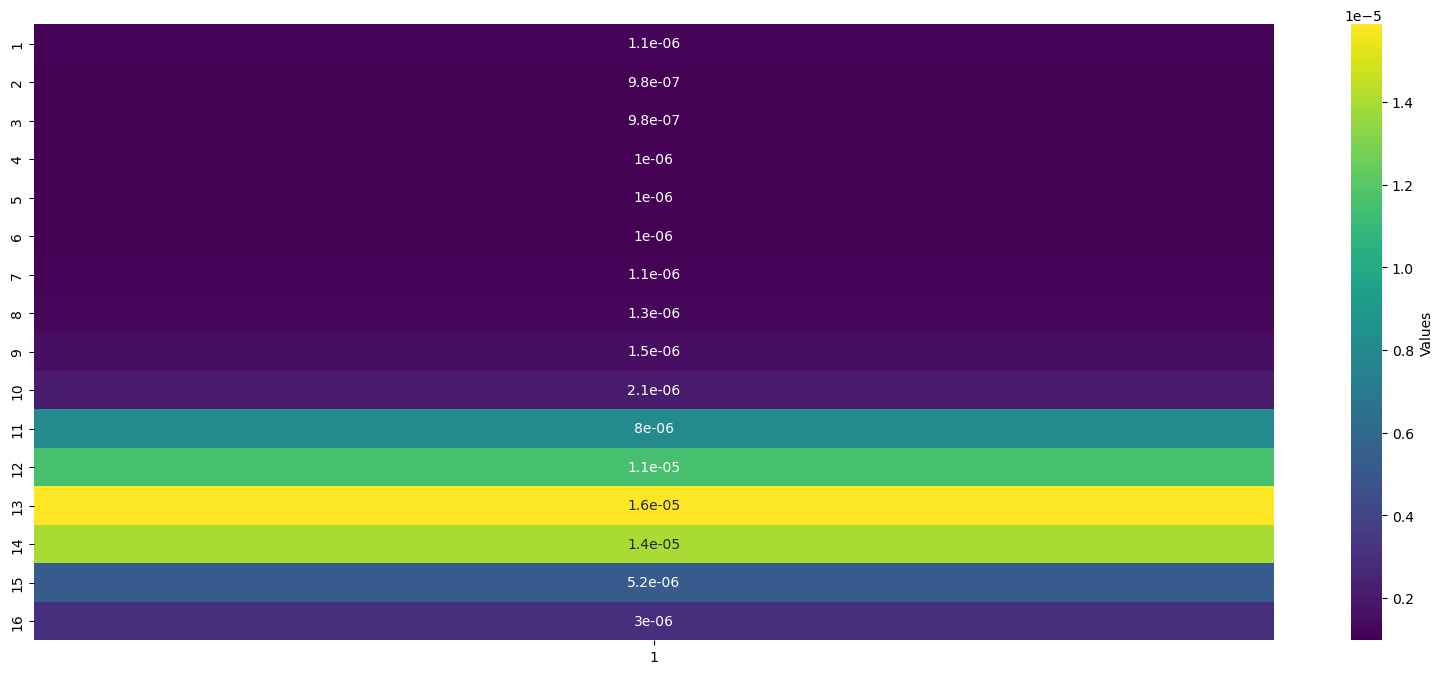

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

plt.figure(figsize=(20, 8))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))

# Display the heatmap
plt.show()

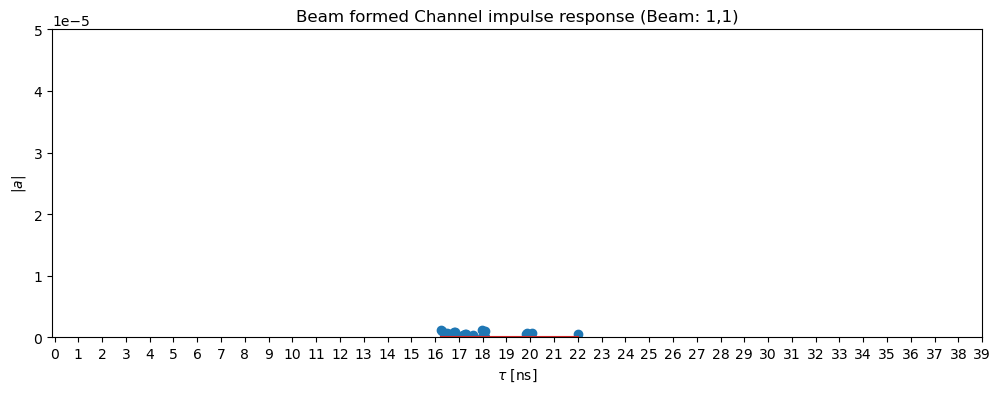

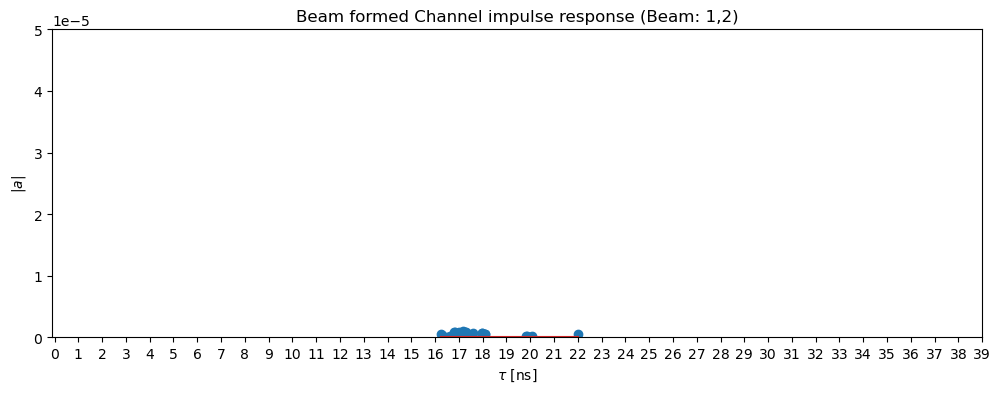

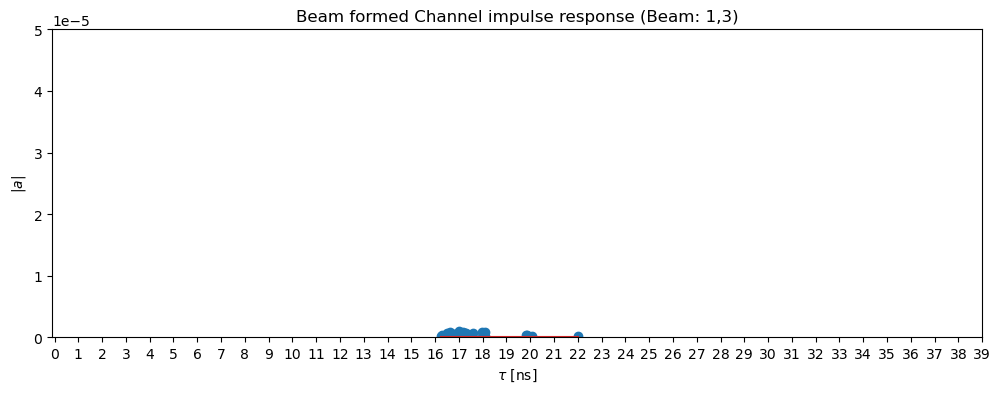

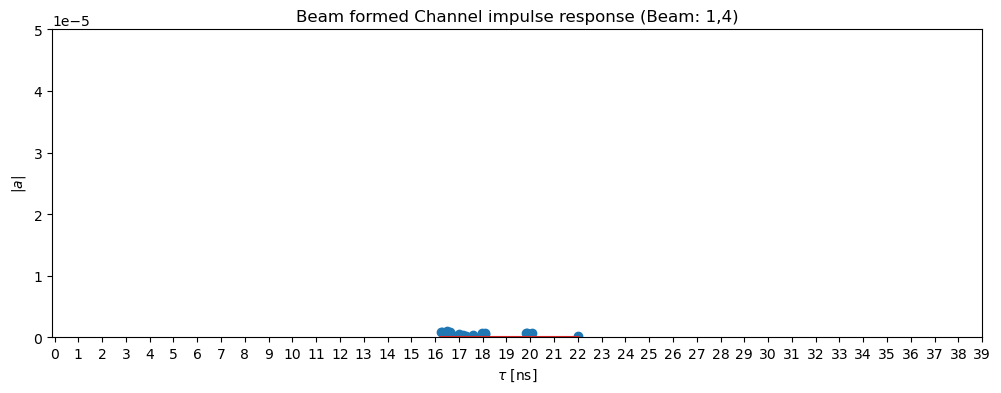

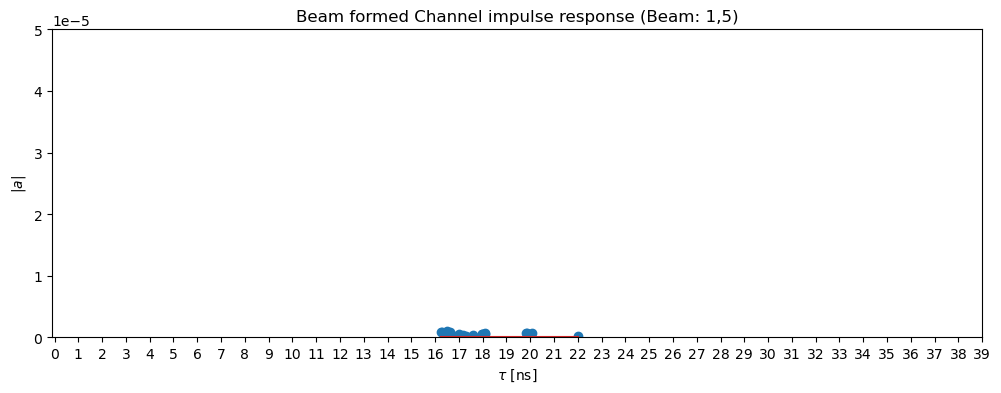

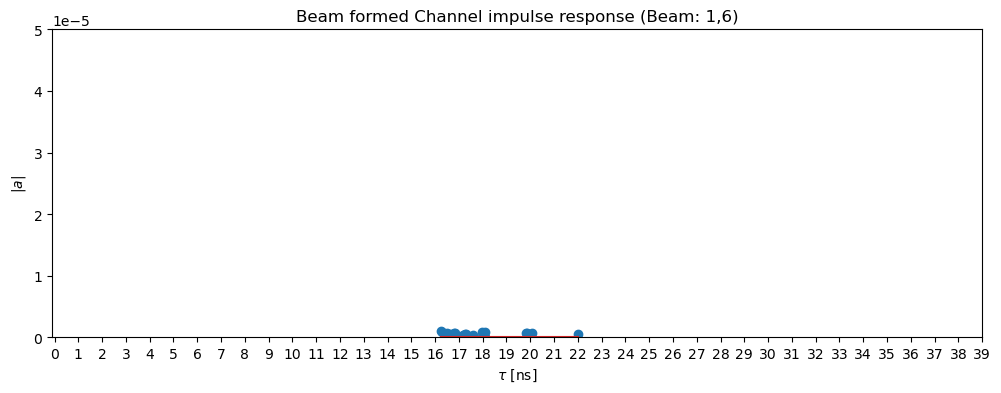

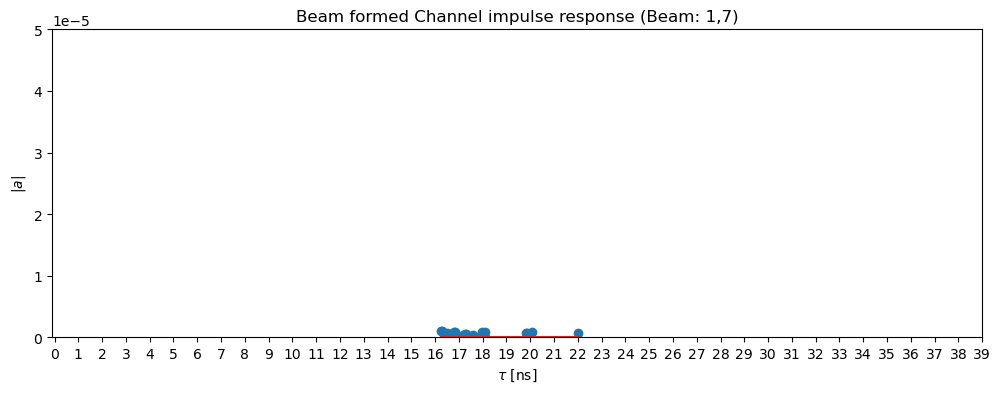

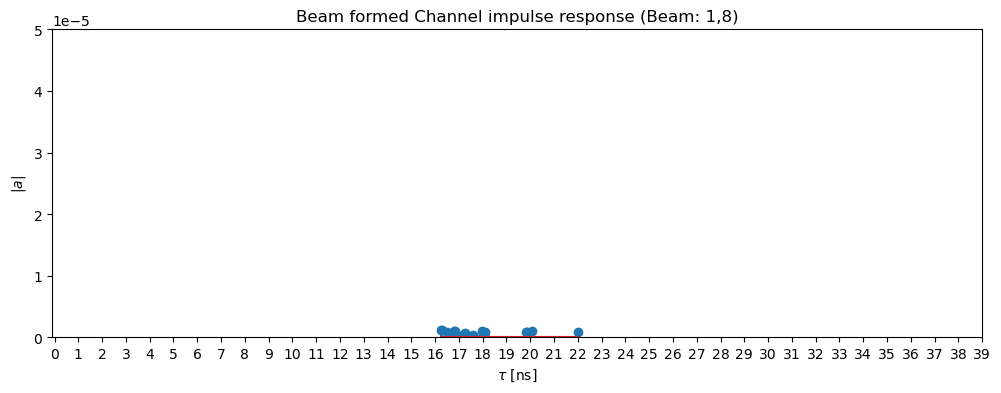

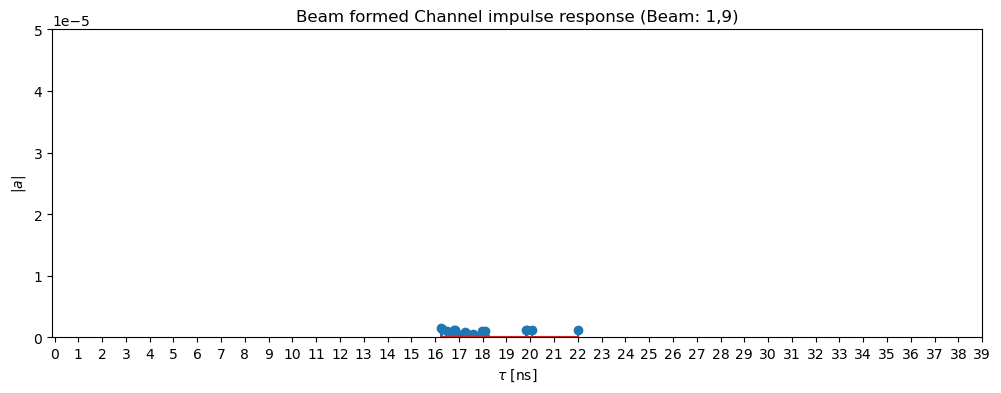

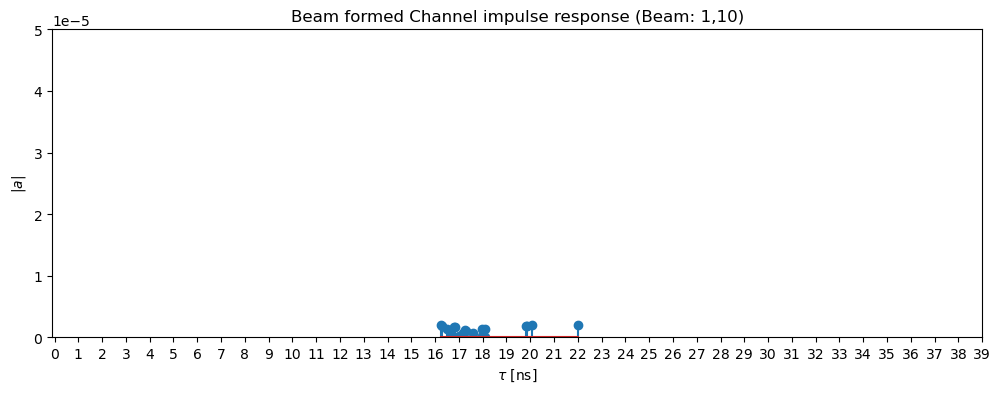

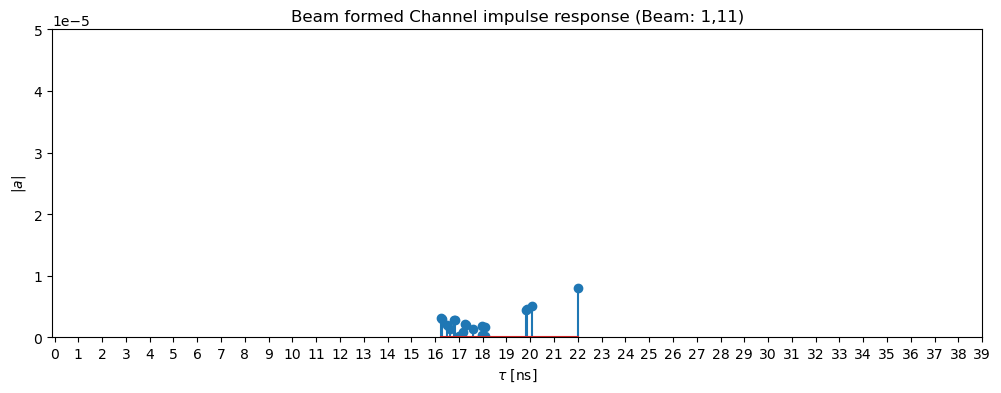

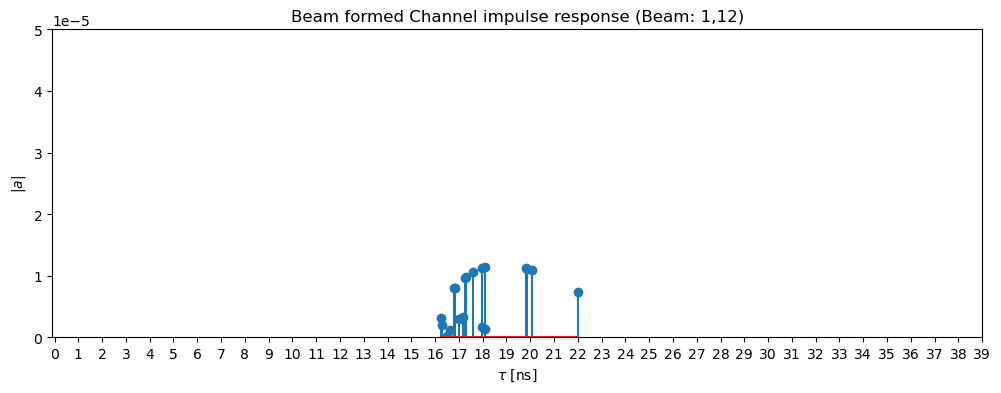

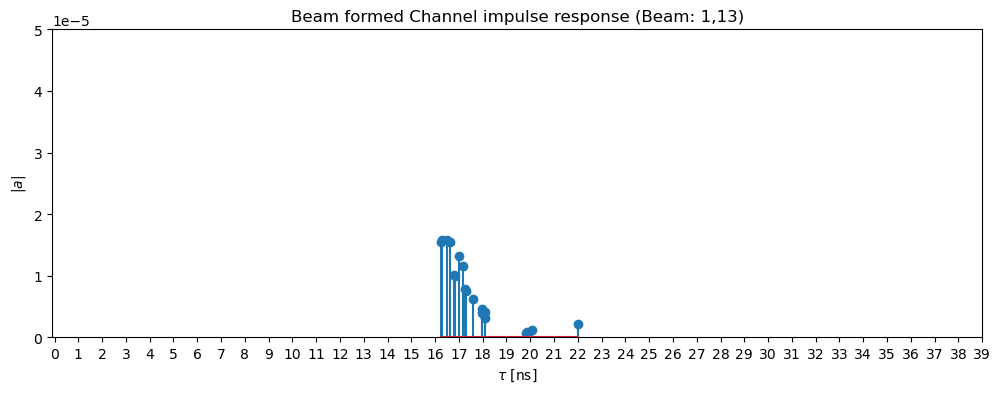

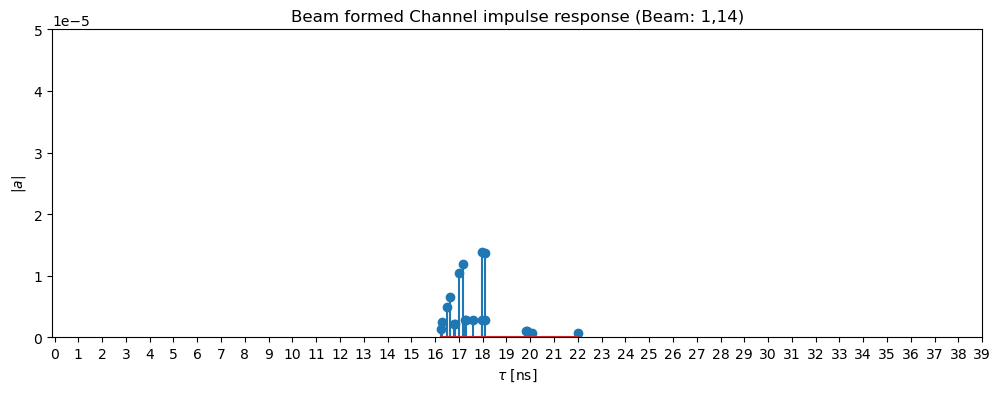

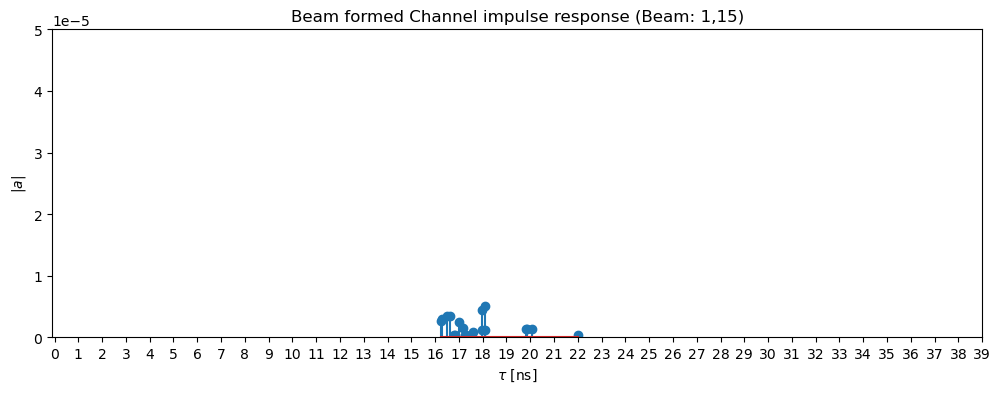

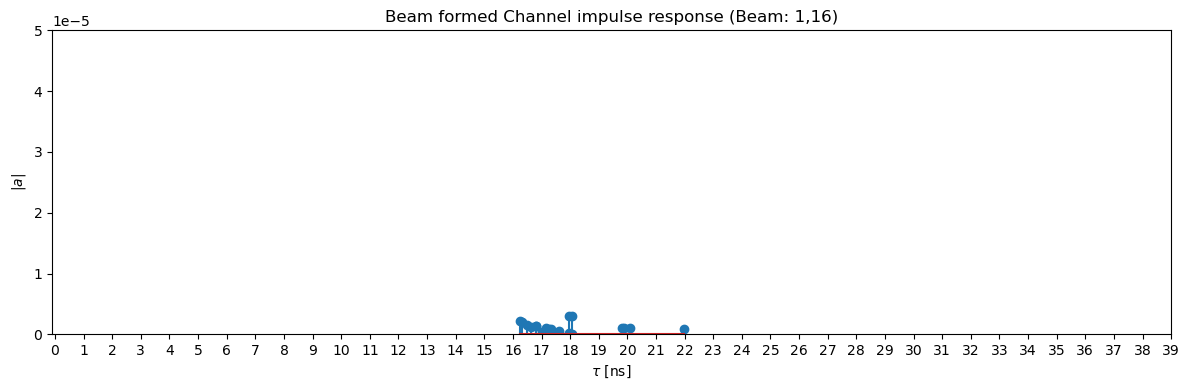

In [24]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 5e-5])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()